In [331]:
#-----------------------------------------------------------------------------#
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
# dummy data using OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#Load training data and transform to analyzable format
df = pd.read_csv('train.csv', index_col=['Id']) 

for col in df.columns:
    if df[col].dtypes == 'object':
        df[col]=df[col].fillna('0') #fill na with 0
    else:
        df[col]=df[col].fillna(0)
        
for col in ['YearBuilt','YearRemodAdd','GarageYrBlt']:
    df[col] = df['YrSold'] - df[col]
#change SalePrice to fold of 1k
df['SalePrice'] = df.SalePrice / 1000
df.shape   

(1460, 80)

In [383]:
# Q1: Bedroom number and or living area, which matters more?
# Solution-1: Plot the ralationship of SalePrice with Living Area with BedRoom information

def plot_bedroom(df,xlim,ylim):
    fig = plt.figure(figsize=(10,7))
    colors = dict(zip(df.BedroomAbvGr.unique(),np.array(['C'+str(s) for s in range(len(df.BedroomAbvGr.unique()))])))
    plt.scatter(df.GrLivArea, df.SalePrice,
                s=df.BedroomAbvGr*30,
                c=df.BedroomAbvGr.replace(colors),alpha=0.5)

    for i in range(len(df.BedroomAbvGr.unique())):
        plt.scatter(0.01,0.01,
                    c='C'+str(i),alpha=0.5,
                    label=df.BedroomAbvGr.unique()[i])
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(title='Bedroom No.')
    plt.xlabel('GrLivArea')
    plt.ylabel('SalePrice (k)')
    plt.show()

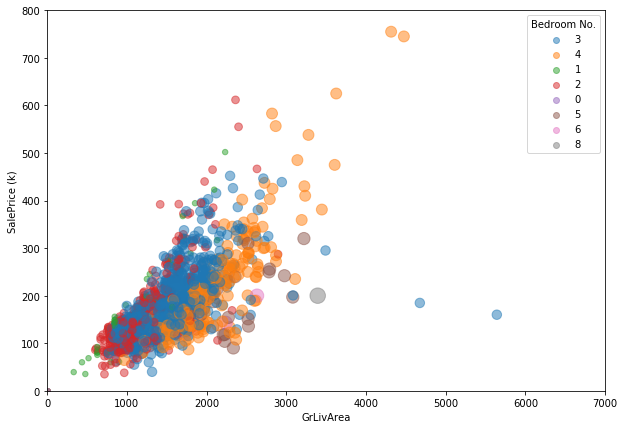

In [384]:
plot_bedroom(df,xlim=[0,7000],ylim=[0,800])

(1460, 80)


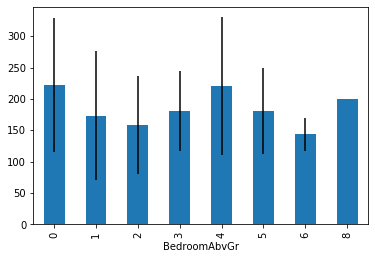

In [391]:
df0 = df
print(df0.shape)
mean = df0.groupby('BedroomAbvGr').SalePrice.mean()
sd = df0.groupby('BedroomAbvGr').SalePrice.std()
mean.plot(kind='bar',yerr=sd)

(1229, 80)


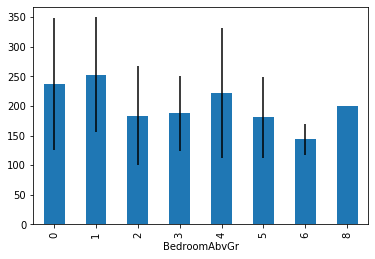

In [392]:
df1000 = df[df.GrLivArea > 1000]
print(df1000.shape)
mean = df1000.groupby('BedroomAbvGr').SalePrice.mean()
sd = df1000.groupby('BedroomAbvGr').SalePrice.std()
mean.plot(kind='bar',yerr=sd)

(214, 80)


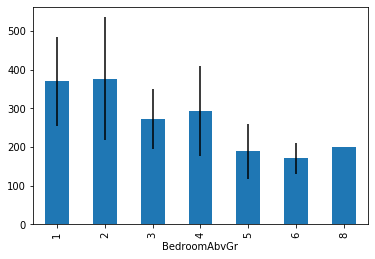

In [336]:
df2000 = df[df.GrLivArea > 2000]
print(df_temp.shape)
mean = df2000.groupby('BedroomAbvGr').SalePrice.mean()
sd = df2000.groupby('BedroomAbvGr').SalePrice.std()
mean.plot(kind='bar',yerr=sd)

In [342]:
def plot_corr(df,col):
    fig = plt.figure(figsize=(10,7))

    colors = dict(zip(df[col].unique(),np.array(['C'+str(s) for s in range(len(df[col].unique()))])))
    plt.scatter(df.GrLivArea, df.SalePrice,
                s=df.BedroomAbvGr*30,
                c=df[col].replace(colors),alpha=0.5)

    for i in range(len(df[col].unique())):
        plt.scatter(0.01,0.01,
                    c='C'+str(i),alpha=0.5,
                    label=df[col].unique()[i])

    plt.legend(title=col)
    plt.xlabel('Living Area')
    plt.ylabel('SalePrice (k)')
    plt.show()



In [338]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

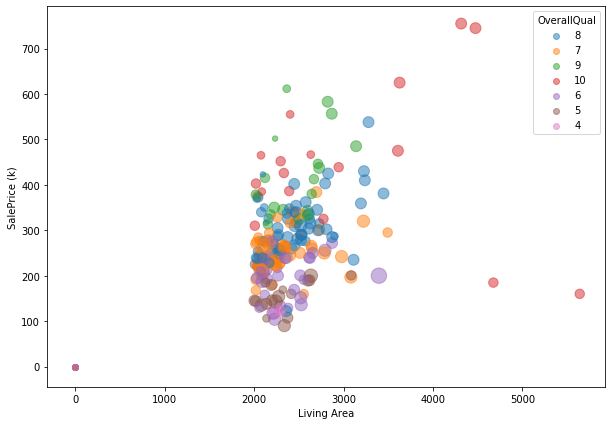

In [344]:
plot_corr(df2000,'OverallQual')

Text(0, 0.5, 'OverallQual')

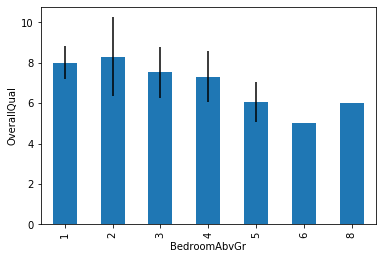

In [353]:
mean = df2000.groupby('BedroomAbvGr').OverallQual.mean()
sd = df2000.groupby('BedroomAbvGr').OverallQual.std()
mean.plot(kind='bar',yerr=sd)
plt.xlabel('BedroomAbvGr')
plt.ylabel('OverallQual')

Text(0, 0.5, 'BsmtUnfSF')

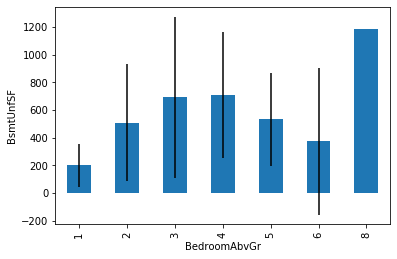

In [359]:
mean = df2000.groupby('BedroomAbvGr').BsmtUnfSF.mean()
sd = df2000.groupby('BedroomAbvGr').BsmtUnfSF.std()
mean.plot(kind='bar',yerr=sd)
plt.xlabel('BedroomAbvGr')
plt.ylabel('BsmtUnfSF')

Text(0, 0.5, 'YearRemodAdd')

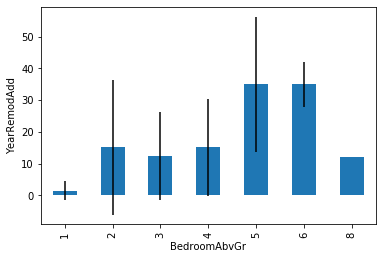

In [369]:
mean = df2000.groupby('BedroomAbvGr').YearRemodAdd.mean()
sd = df2000.groupby('BedroomAbvGr').YearRemodAdd.std()
mean.plot(kind='bar',yerr=sd)
plt.xlabel('BedroomAbvGr')
plt.ylabel('YearRemodAdd')

In [360]:
# choose the model according to modeling
import xgboost as xgb
model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.15,
             max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
             n_estimators=250, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.65, verbosity=1)

In [361]:
y_train = df.SalePrice
X_train = df.drop('SalePrice',axis=1)

le = LabelEncoder()
X_train = X_train.apply(lambda x: le.fit_transform(x))

categorical_mask = (X_train.dtypes == 'object')

ohe = OneHotEncoder(categorical_features=categorical_mask, sparse=False)
X_train = ohe.fit_transform(X_train)

model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.15, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=None, n_estimators=250,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.65, verbosity=1)

In [377]:
df_predict = df
df_predict.SalePrice = model.predict(X_train)


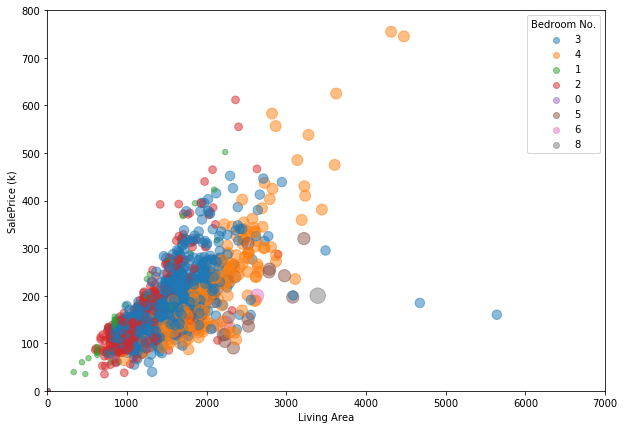

In [378]:
plot_bedroom(df_predict,xlim=[0,7000],ylim=[0,800])

In [398]:
# simulation with everything is the same but only change bedroom numbers randomly.

def simulate_bedroom(df_s):
    n = df_s.shape[0]
    loc = np.random.randint(0,n)
    data = df_s.iloc[loc] # choose a random number to assign all the other attributes
    print(loc, data.GrLivArea)
    
    for col in df_s.columns:
        if col == 'BedroomAbvGr':
            df_s[col] = [np.random.randint(1,6) for i in range(n)] # randomize bedroom numbers
        elif col == 'GrLivArea':
            pass
        else:
            df_s[col] = [data[col] for i in range(n)]
    
    return df_s

In [394]:
def simulation_price(model,df_new):
    X = df_new
    X = X.apply(lambda x: le.fit_transform(x))
    X = ohe.fit_transform(X)

    df_new['SalePrice'] = model.predict(X)
    
    return df_new

In [395]:

df1 = df.drop('SalePrice',axis=1)[df.GrLivArea>2000]
print(df1.shape)

(214, 79)


96 2340


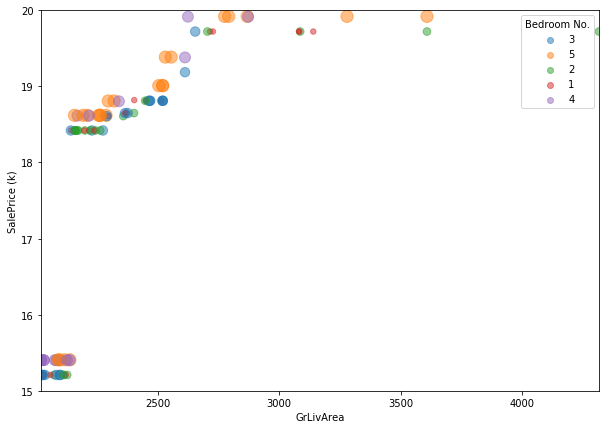

15 2217


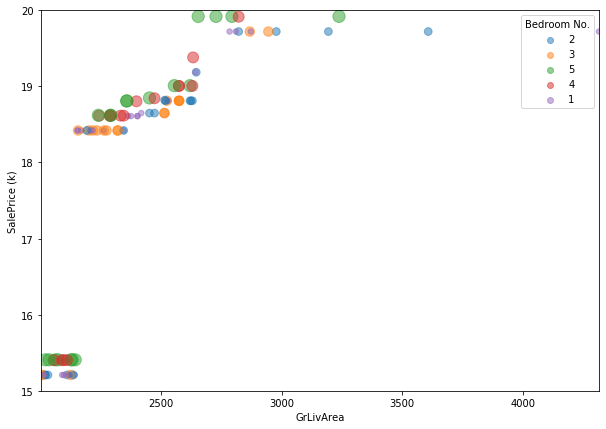

59 2076


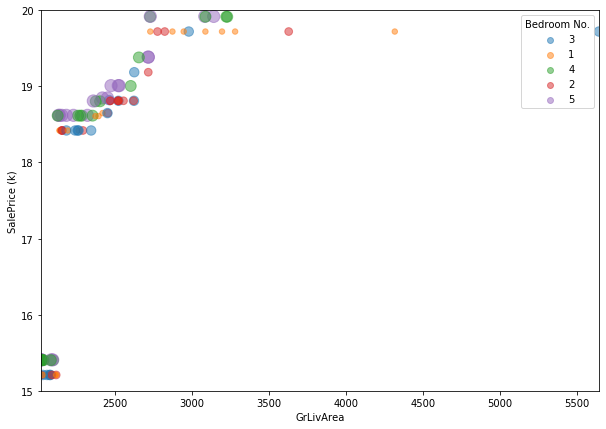

2 2113


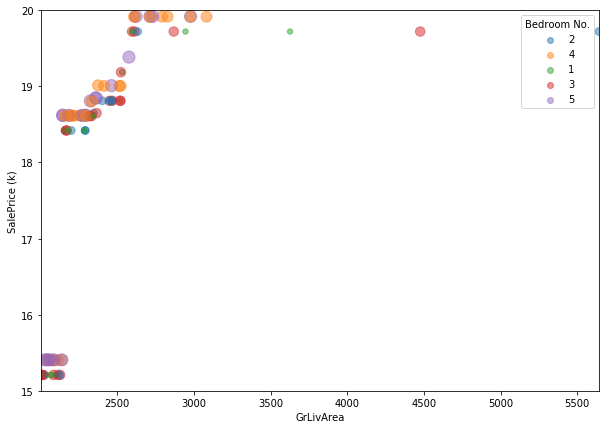

30 3627


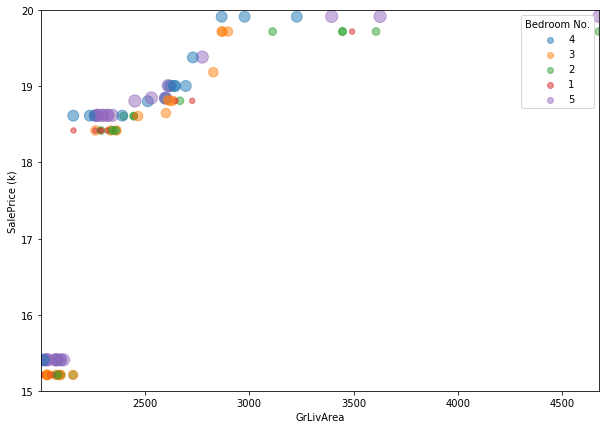

CPU times: user 1.87 s, sys: 98.3 ms, total: 1.97 s
Wall time: 2.15 s


In [399]:
%%time

for i in range(5):
    
    df_s = df1.sample(n=100,replace=True)
    df_new = simulate_bedroom(df_s)

    y = simulation_price(model,df_new)
    plot_bedroom(df_new,
                 [math.floor(df_new.GrLivArea.min()),math.ceil(df_new.GrLivArea.max())],
                 [math.floor(df_new.SalePrice.min()),math.ceil(df_new.SalePrice.max())])


In [400]:
def simulate_bedroom_more(df_s):
    n = df_s.shape[0]
    loc = np.random.randint(0,n)
    data = df_s.iloc[loc] # choose a random number to assign all the other attributes
    print(loc, data.GrLivArea)
    
    for col in df_s.columns:
        if col == 'BedroomAbvGr':
            df_s[col] = [np.random.randint(1,6) for i in range(n)] # randomize bedroom numbers
        elif col == 'YearRemodAdd':
            df_s[col] = [np.random.randint(1,6)*4 for i in range(n)] 
        elif col == 'GrLivArea':
            pass
        else:
            df_s[col] = [data[col] for i in range(n)]
    
    return df_s

(214, 79)
4 2414


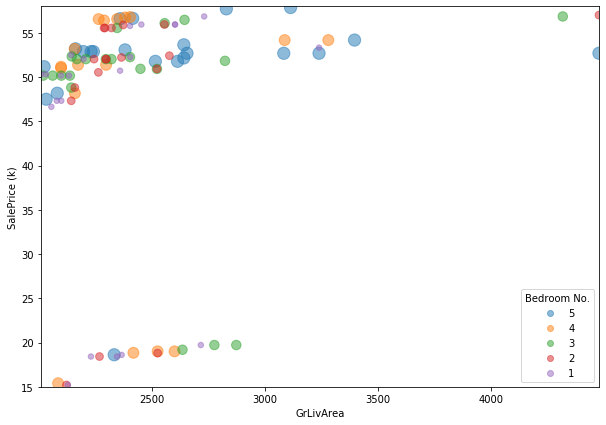

8 2402


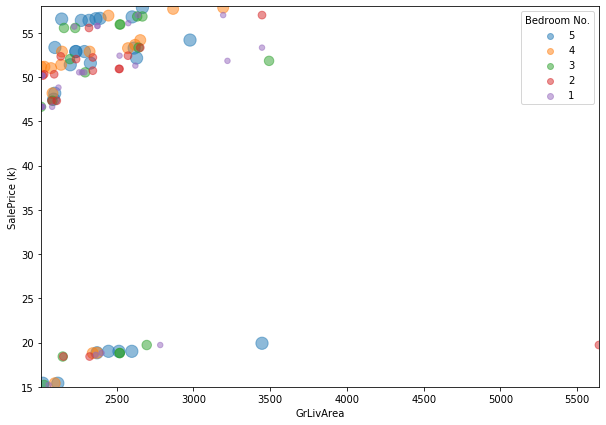

89 2207


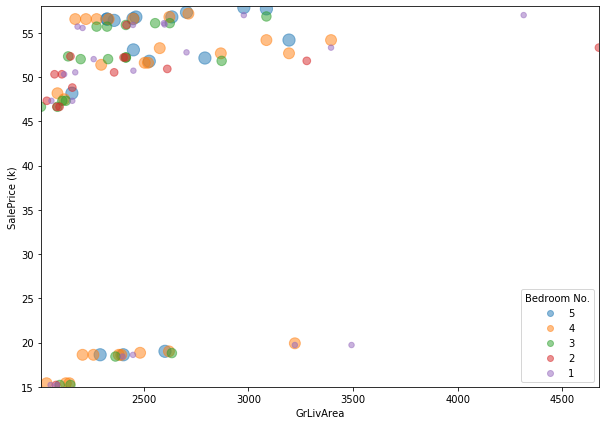

45 2127


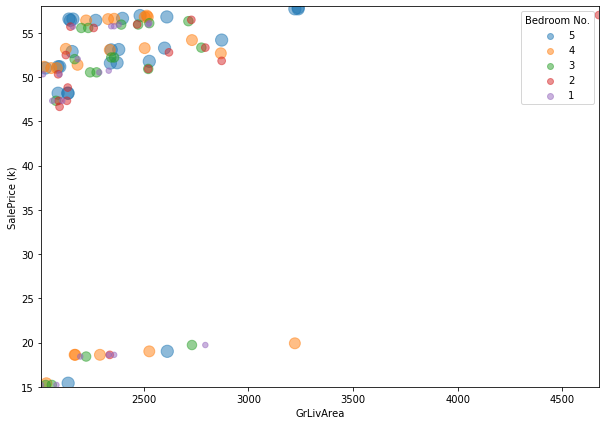

44 2555


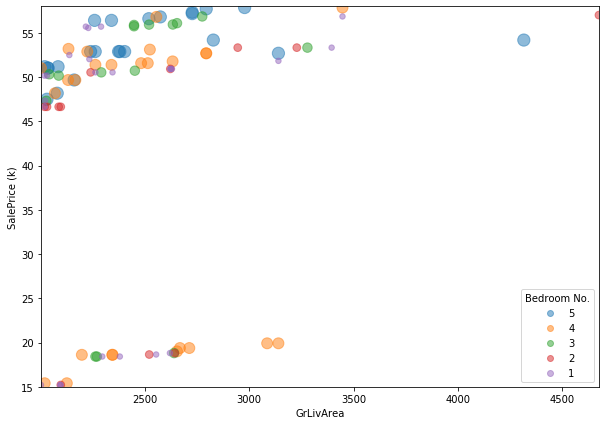

In [401]:
df2 = df.drop('SalePrice',axis=1)[df.GrLivArea>2000]
print(df1.shape)
for i in range(5):
    
    df_s = df2.sample(n=100,replace=True)
    df_new = simulate_bedroom_more(df_s)

    df_new = simulation_predict(df_new).sort_values(by='BedroomAbvGr', ascending=False)
    plot_bedroom(df_new,
                 [math.floor(df_new.GrLivArea.min()),math.ceil(df_new.GrLivArea.max())],
                 [math.floor(df_new.SalePrice.min()),math.ceil(df_new.SalePrice.max())])
